In [1]:
import sys
import numpy as np
import pandas as pd
import os
from skimage.transform import resize
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn import cluster

import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold

from sklearn.utils import shuffle

from sklearn import preprocessing

In [2]:
############################################
## Functions

def scaleImgPerc(imgIn, percLow, percHigh):
    if len(imgIn.shape) == 2:
        imgIn = imgIn.reshape([imgIn.shape[0], imgIn.shape[1], 1])
        
    w, h, d = imgIn.shape
    imgIn = np.reshape(imgIn, [w * h, d]).astype(np.float64)
    mins = np.percentile(imgIn, percLow, axis=0)
    ranges = np.percentile(imgIn, percHigh, axis=0) - mins
    imgIn = (imgIn - mins[None, :]) / ranges[None, :]
    imgIn = np.reshape(imgIn, [w, h, d])
    imgIn = imgIn.clip(0, 1)
    return imgIn

def imgToFeatVec(imgIn):
    dataMat = pickle.load(open(imgIn, "rb"))
    dataMat = dataMat[:,:,0].squeeze().flatten()
    return dataMat

In [3]:
############################################
## Hard coded paths and vars
BDIR = '../PrjData/Prj_EuroSat/Out/Data_p20_c2-4-5-8-9'
listImg = BDIR + '/ListImages_p20_c2-4-5-8-9.csv'

SEL_LABEL = 'Forest'
listImg

'../PrjData/Prj_EuroSat/Out/Data_p20_c2-4-5-8-9/ListImages_p20_c2-4-5-8-9.csv'

In [4]:
## Read data
df = pd.read_csv(listImg)
df['MatName'] = BDIR + '/ImagesMat/' + df.ImgName + '.p'


In [5]:
## Binarize categories (selected label=1, others=0)
df['CAT'] = 0
df.loc[df.CType==SEL_LABEL, 'CAT'] = 1

featVecSize = imgToFeatVec(df.MatName[0]).shape[0]
dataMat = np.zeros([df.shape[0], featVecSize])

for i, tmpRow in df.iterrows():
    dataMat[i,:] = imgToFeatVec(tmpRow.MatName)
labels = np.array(df.CAT)


## Split sample training/testing

In [7]:
### Select balanced training data
indPos = np.where(labels==1)[0]
indNeg = shuffle(np.where(labels==0)[0], random_state=42)[0:indPos.shape[0]]

indBal = shuffle(np.concatenate([indPos,indNeg]), random_state=42)

XBal = dataMat[indBal, :]
YBal = labels[indBal]

scaler = preprocessing.StandardScaler().fit(XBal)
XBalSc = scaler.transform(XBal)

X = XBalSc
y = YBal

X_train, X_test, y_train, y_test = train_test_split(XBalSc, YBal, stratify = YBal, train_size = 0.5, random_state=42)

In [8]:
svc = SVC(kernel='linear')

print('Train size: ' + str(y_train.shape[0]))

### Training the model
print('Training the model ...')
svc.fit(X_train, y_train)

print('Applying the model ...')
yPred = svc.predict(X_test)

Train size: 600
Training the model ...
Applying the model ...


In [9]:
print( 'Accuracy: ' + str(100 * np.sum(yPred==y_test) / y_test.shape[0]))

Accuracy: 84.83333333333333


## k-Fold Cross-Validation (CV)

In [19]:
NUM_FOLD = 4 

from sklearn.model_selection import KFold
kf = KFold(n_splits=4)

yPredAll = np.zeros(y.shape[0])
accAll = np.zeros(NUM_FOLD)

svc = SVC(kernel='linear')

indFold = 0
for train_index, test_index in kf.split(X):

    XTrain   = X[train_index]
    yTrain = y[train_index]

    XTest    = X[test_index]
    yTest  = y[test_index]

    ### Training the model
    print('Training the model for fold: ' + str(indFold))
    svc.fit(XTrain, yTrain)

    yPred = svc.predict(XTest)

    # accuracy for the current fold only    
    accFold = np.sum(yPred==yTest) / yTest.shape[0]
    accAll[indFold] = accFold
    print('  Acc : ' + str(accFold))
    
    yPredAll[test_index] = yPred

    indFold = indFold + 1

# Average accuracy over all folds
accAvg = np.mean(accAll)
print('Avg Acc. :' + str(accAvg))

acc =  np.sum(y==yPredAll) / y.shape[0]
print('Acc. for the combined folds :' + str(acc))


Training the model for fold: 0
  Acc : 0.8533333333333334
Training the model for fold: 1
  Acc : 0.86
Training the model for fold: 2
  Acc : 0.8366666666666667
Training the model for fold: 3
  Acc : 0.8266666666666667
Avg Acc. :0.8441666666666666
Acc. for the combined folds :0.8441666666666666


## k-Fold Cross-Validation using scikit functions

In [21]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(svc, X, y, cv=4))

[0.84333333 0.84       0.85333333 0.84333333]


## Cross-validated parameter optimization

In [ ]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X, y)

In [28]:
clf.cv_results_

{'mean_fit_time': array([2.21170831, 1.03902817, 5.61492364, 0.90800118]),
 'std_fit_time': array([0.04443957, 0.04076918, 0.3832568 , 0.02782958]),
 'mean_score_time': array([0.45853202, 0.43688019, 0.45555965, 0.37071403]),
 'std_score_time': array([0.02337551, 0.02089812, 0.00136054, 0.01174374]),
 'param_C': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_kernel': masked_array(data=['linear', 'rbf', 'linear', 'rbf'],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 1, 'kernel': 'linear'},
  {'C': 1, 'kernel': 'rbf'},
  {'C': 10, 'kernel': 'linear'},
  {'C': 10, 'kernel': 'rbf'}],
 'split0_test_score': array([0.825 , 0.8725, 0.8175, 0.91  ]),
 'split1_test_score': array([0.84  , 0.8975, 0.8175, 0.9325]),
 'split2_test_score': array([0.845 , 0.8825, 0.825 , 0.925 ]),
 'mean_test_score': array([0.83666667, 0.88416667, 0.82

## Nested cross-validation
- Inner loop: parameter optimization
- Outer loop: k-fold CV to calculate test accuracy

https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html

Automatically created module for IPython interactive environment
Ind trial: 0
Ind trial: 1
Ind trial: 2
Ind trial: 3
Ind trial: 4
Average difference of 0.020007 with std. dev. of 0.004218.


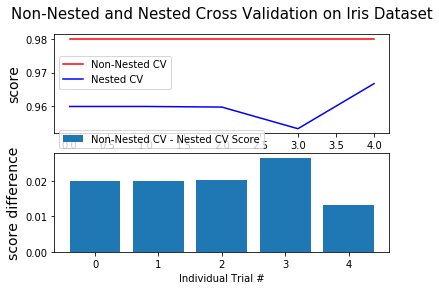

In [41]:
from sklearn.datasets import load_iris
from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
import numpy as np

import warnings
warnings.filterwarnings('ignore')

print(__doc__)

# Number of random trials
NUM_TRIALS = 50
NUM_TRIALS = 5

# Load the dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100],
          "gamma": [.01, .1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)


# Loop for each trial
for i in range(NUM_TRIALS):

    print('Ind trial: ' + str(i))
    
    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    #clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    clf.fit(X, y)
    clf.fit(X_iris, y_iris)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    nested_score = cross_val_score(clf, X=X_iris, y=y_iris, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print("Average difference of {:6f} with std. dev. of {:6f}."
      .format(score_difference.mean(), score_difference.std()))

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
non_nested_scores_line, = plt.plot(non_nested_scores, color='r')
nested_line, = plt.plot(nested_scores, color='b')
plt.ylabel("score", fontsize="14")
plt.legend([non_nested_scores_line, nested_line],
           ["Non-Nested CV", "Nested CV"],
           bbox_to_anchor=(0, .4, .5, 0))
plt.title("Non-Nested and Nested Cross Validation on Iris Dataset",
          x=.5, y=1.1, fontsize="15")

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend([difference_plot],
           ["Non-Nested CV - Nested CV Score"],
           bbox_to_anchor=(0, 1, .8, 0))
plt.ylabel("score difference", fontsize="14")

plt.show()

In [36]:
X.shape
y.shape
XBal.shape


(1200, 4096)